# Imports



In [72]:
from numpy.random import seed
seed(888)
import os
import itertools
import numpy as np
import tensorflow as tf 
from tensorflow import keras


from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import array_to_img
from keras.callbacks import TensorBoard

tf.random.set_seed(404)

from IPython.display import display
from time import strftime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Constants 

In [2]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog',  'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get the Data

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

# Explore Data

In [4]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

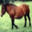

In [5]:
pic = array_to_img(x_train_all[7])
display(pic)

In [6]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

# Preprocess Data

In [7]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255
x_train_all[0][0][0][0]

0.23137254901960785

In [8]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)
x_train_all.shape

(50000, 3072)

In [9]:
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
x_test.shape


(10000, 3072)

# Create Validation Dataset

In [10]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
y_val.shape


(10000, 1)

# Resize training dataset

In [11]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
y_train.shape


(40000, 1)

### create subset of training data for ease and speed of development 

In [12]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network 

In [28]:
model_1 = Sequential([
    Dense(units = 128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units = 64, activation='relu', name='m1_hidden2'),
    Dense(units = 16, activation='relu' , name='m1_hidden3'),
    Dense(units = 10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
type(model_1)

keras.engine.sequential.Sequential

In [38]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS, )))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
type(model_2)

keras.engine.sequential.Sequential

In [30]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS, )))
model_3.add(Dense(128, activation='relu', name='m3_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(16, activation='relu', name='m3_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m3_output'))

model_3.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
type(model_3)

keras.engine.sequential.Sequential

In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


# Tensorboard 

In [15]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err: 
        print(err.strerror)
    else:
        print('success')
    return TensorBoard(log_dir=dir_paths)

# Fitting the Model 

In [17]:
samples_per_batch = 1000

In [34]:
%%time
nr_epochs = 100
model_1.fit(x_train, y_train, batch_size = samples_per_batch, verbose=0, 
            epochs = nr_epochs, callbacks = [get_tensorboard('Model 1 XL')], validation_data=(x_val, y_val))

success
CPU times: total: 16min 9s
Wall time: 1min 53s


In [32]:
%%time
nr_epochs = 100
model_2.fit(x_train, y_train, batch_size = samples_per_batch, verbose=0, 
            epochs = nr_epochs, callbacks = [get_tensorboard('Model 2 XL')], validation_data=(x_val, y_val))

success
CPU times: total: 17min 36s
Wall time: 1min 40s


In [46]:
%%time
nr_epochs = 100
model_3.fit(x_train, y_train, batch_size = samples_per_batch, verbose=0, 
            epochs = nr_epochs, callbacks = [get_tensorboard('Model 3 XL')], validation_data=(x_val, y_val))

success
CPU times: total: 17min 32s
Wall time: 1min 53s


# Predictions with Trained Model 


In [47]:
for number in range(10):
    test_img = np.expand_dims(x_val[number], axis=0)
    
    predict = model_3.predict(test_img)
    class_test = np.argmax(predict, axis=1)
#     predicted_val = model_2.predict_classes(test_img)[0]
    print(f'Actual valude: {y_val[number][0]} vs predicted: {class_test[0]}')

1/1 [==============================] - 0s 17ms/step
Actual valude: 6 vs predicted: 6
1/1 [==============================] - 0s 15ms/step
Actual valude: 9 vs predicted: 1
1/1 [==============================] - 0s 17ms/step
Actual valude: 9 vs predicted: 9
1/1 [==============================] - 0s 14ms/step
Actual valude: 4 vs predicted: 6
1/1 [==============================] - 0s 15ms/step
Actual valude: 1 vs predicted: 1
1/1 [==============================] - 0s 15ms/step
Actual valude: 1 vs predicted: 9
1/1 [==============================] - 0s 15ms/step
Actual valude: 2 vs predicted: 2
1/1 [==============================] - 0s 15ms/step
Actual valude: 7 vs predicted: 7
1/1 [==============================] - 0s 15ms/step
Actual valude: 8 vs predicted: 8
1/1 [==============================] - 0s 15ms/step
Actual valude: 3 vs predicted: 9


# Evaluation and Review

In [55]:
model_3.metrics_names

['loss', 'accuracy']

In [60]:
test_loss, test_accuracy = model_3.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

313/313 [==============================] - 0s 971us/step - loss: 1.4236 - accuracy: 0.4958
Test loss is 1.42 and test accuracy is 49.6%


## Confusion Matrix

In [64]:
def generate_classes(model_name, test_data):
    predict = model_name.predict(test_data)
    class_test = np.argmax(predict, axis=1)
    return class_test

In [65]:
predictions = generate_classes(model_3, x_test)
conf_matrix = confusion_matrix(y_true = y_test, y_pred = predictions)

313/313 [==============================] - 0s 792us/step


In [66]:
conf_matrix.shape

(10, 10)

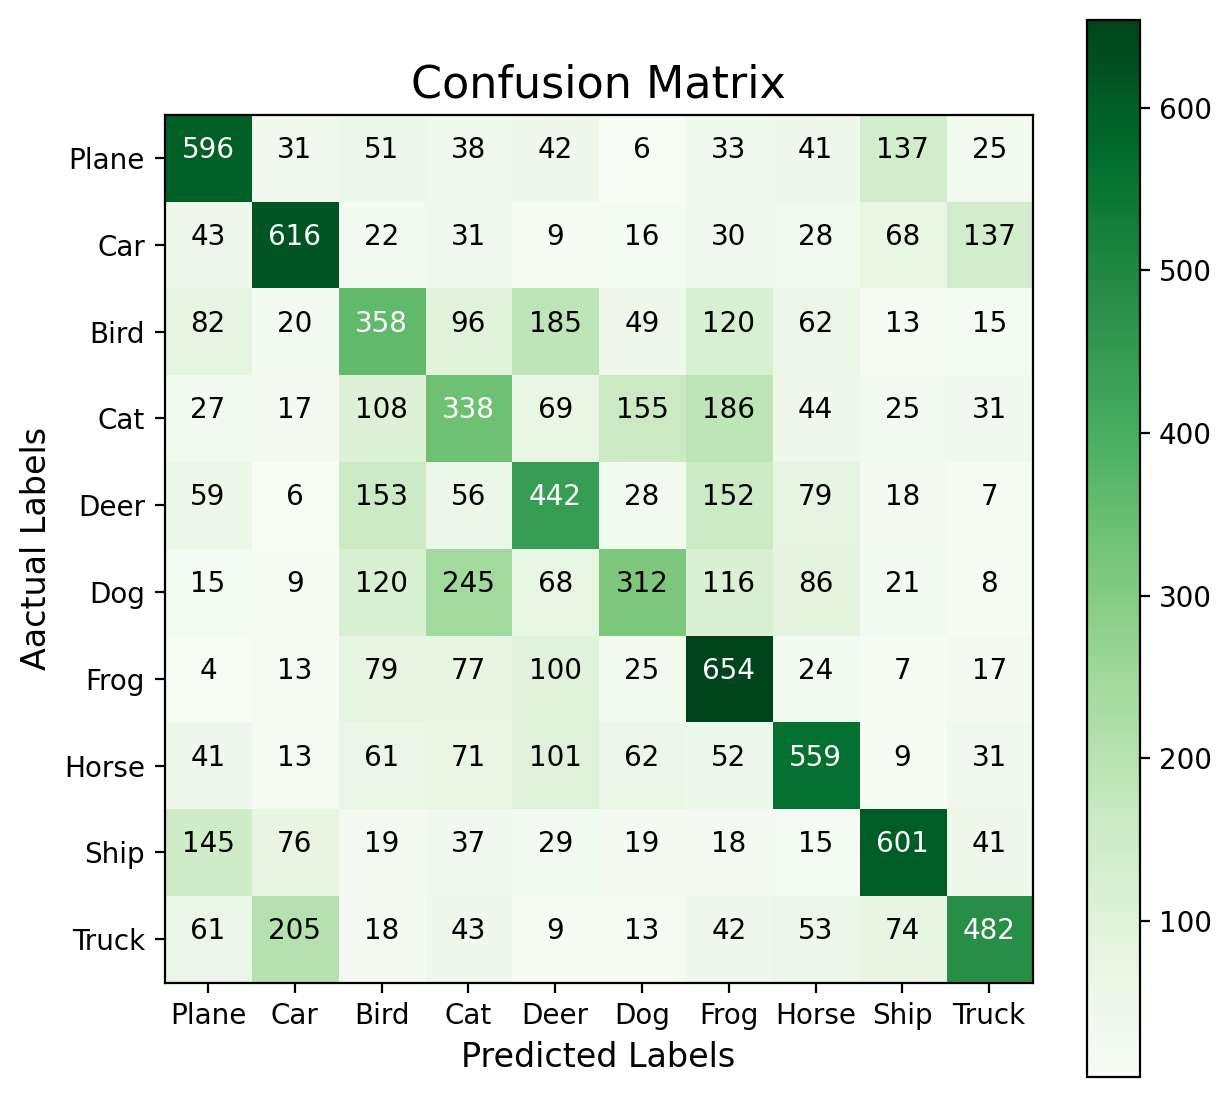

In [78]:
plt.figure(figsize = (7,7), dpi=200)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('Aactual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)
tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()
for i, j in itertools.product(range(10), range(10)):
    plt.text(j, i, conf_matrix[i,j], horizontalalignment='center',
            color='white' if conf_matrix[i,j] > conf_matrix.max()/2 else 'black')
plt.show()

In [81]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.596, 0.616, 0.358, 0.338, 0.442, 0.312, 0.654, 0.559, 0.601,
       0.482])

In [82]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.555452  , 0.61232604, 0.3619818 , 0.32751938, 0.41935484,
       0.45547445, 0.46614398, 0.56407669, 0.61767729, 0.6070529 ])

In [83]:
avg_recall = np.mean(recall)
print(f'Model 3 recall score is {avg_recall: .2%}')

Model 3 recall score is  49.58%


In [84]:
avg_precision = np.mean(precision)
print(f'Model 3 precision score is {avg_precision: .2%}')

Model 3 precision score is  49.87%


In [86]:
f1_score = 2 * (avg_precision * avg_recall) / (avg_recall + avg_precision)
f1_score

0.4972487229021067